Here, we will put in place a framework to filter SNP data.
Rather than giving you filtering rules (an impossible task to be performed in a general way), we will
give you procedures to assess the quality of your data. With this, you can devise your own filters.

**In the best-case scenario,** you have a VCF file with proper filters applied. If this is the case, you can
just go ahead and use your file. Note that all VCF files will have a FILTER column, but this might not
mean that all of the proper filters were applied. You have to be sure that your data is properly filtered.
</br>
**In the second case,** which is one of the most common, your file will have unfiltered data, but you’ll
have enough annotations and can apply hard filters (there is no need for programmatic filtering). If
you have a GATK annotated file, refer to http://gatkforums.broadinstitute.org/
discussion/2806/howto-apply-hard-filters-to-a-call-set.
</br>
**In the third case,** you have a VCF file that has all the annotations that you need, but you may want to
apply more flexible filters (for example, “if read depth > 20, accept if mapping quality > 30; otherwise,
accept if mapping quality > 40”).
</br>
**In the fourth case,** your VCF file does not have all the necessary annotations and you have to revisit
your BAM files (or even other sources of information). In this case, the best solution is to find whatever
extra information you can and create a new VCF file with the required annotations. Some genotype
callers (such as GATK) allow you to specify which annotations you want; you may also want to use extra
programs to provide more annotations. For example, SnpEff (http://snpeff.sourceforge.
net/) will annotate your SNPs with predictions of their effect (for example, if they are in exons, are
they coding or non-coding?).

In this recipe, we will not use data from the human 1,000 Genomes Project. We want dirty, unfiltered data
that has a lot of common annotations that can be used to filter it. We will use data from the Anopheles
gambiae 1,000 Genomes Project (Anopheles is a mosquito vector involved in the transmission of a
parasite that causes malaria), which makes filtered and unfiltered data available. You can find more
information on this project at http://www.malariagen.net/projects/vector/
ag1000g.

We will get a part of the centromere of chromosome 3L for around 100 mosquitoes, which is followed
by a part somewhere in the middle of this chromosome (and index both):

In [3]:
!tabix -fh ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:1-200000 |bgzip -c > centro.vcf.gz

In [4]:
!tabix -fh ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:21000001-21200000|bgzip -c > standard.vcf.gz

In [5]:
!tabix -p vcf centro.vcf.gz

In [6]:
!tabix -p vcf standard.vcf.gz

**Let’s start by plotting the distribution of variants across the genome in both files:**

For both files, we will compute windowed statistics. We will divide our file, which includes
200,000 bp of data, into windows of size 2,000 (100 windows). Every time we find a biallelic
SNP, we will add a 1 to the list related to this window in the window function.
</br></br>
The window function will take a VCF record (a `rec.is_snp` SNP that is not biallelic len
(`rec.ALT) == 1`), determine the window where that record belongs (by performing an
integer division of rec.POS by size), and extend the list of results of that window by the
function passed to it as the fun parameter (which, in our case, is just a 1).
So, now we have a list of 100 elements (each representing 2,000 bp). Each element will be
another list that will have a 1 for each biallelic SNP found.
So, if you have 200 SNPs in the first 2,000 bp, the first element of the list will have 200 ones.

In [8]:
from collections import defaultdict
import functools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cyvcf2 import VCF
def do_window(recs, size, fun):
  start = None
  win_res = []
  for rec in recs:
    if not rec.is_snp or len(rec.ALT) > 1:
      continue
    if start is None:
      start = rec.POS
    my_win = 1 + (rec.POS - start) // size
    while len(win_res) < my_win:
      win_res.append([])
    win_res[my_win - 1].extend(fun(rec))
  return win_res
wins = {}
size = 2000
names = ['centro.vcf.gz', 'standard.vcf.gz']
for name in names:
  recs = VCF(name)
  wins[name] = do_window(recs, size, lambda x: [1])

**Let’s continue, as follows:**

Here, we perform a plot that contains statistical information for each of our 100 windows.
`apply_win_funs` will calculate a set of statistics for every window. In this case, it will sum all the numbers in the window. Remember that every time we find an SNP, we add 1 to
the window list. This means that if we have 200 SNPs, we will have 200 ones; hence, summing
them will return 200.
</br>
So, we are able to compute the number of SNPs per window in an apparently convoluted way.
Why we perform things with this strategy will become apparent soon. 

Text(0.5, 0.98, 'Number of bi-allelic SNPs along the genome')

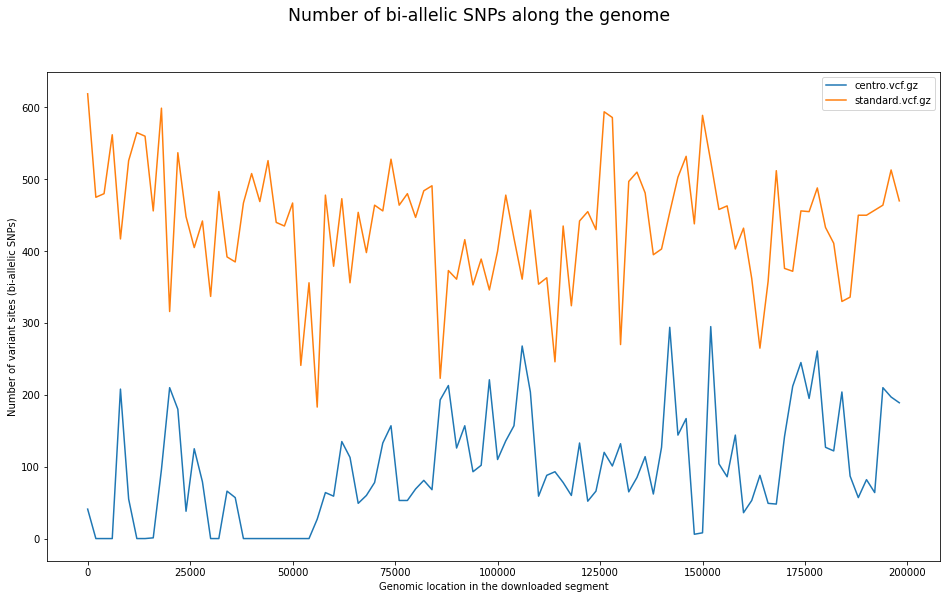

In [9]:
def apply_win_funs(wins, funs):
  fun_results = []
  for win in wins:
    my_funs = {}
    for name, fun in funs.items():
      try:
        my_funs[name] = fun(win)
      except:
        my_funs[name] = None
    fun_results.append(my_funs)
  return fun_results

stats = {}
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in wins.items():
  stats[name] = apply_win_funs(nwins, {'sum': sum})
  x_lim = [i * size for i in range(len(stats[name]))]
  ax.plot(x_lim, [x['sum'] for x in stats[name]],
label=name)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('Number of variant sites (bi-allelic SNPs)')
fig.suptitle('Number of bi-allelic SNPs along the genome', fontsize='xx-large')

**Let’s take a look at the sample-level annotation.**
</br>
 We will inspect mapping quality
zero (refer to https://www.broadinstitute.org/gatk/guide/tooldocs/org_broadinstitute_gatk_tools_walkers_annotator_MappingQualityZeroBySample.php for details), which is a measure of how well sequences involved in calling this variant map clearly to this position. Note that there is also
an MQ0 annotation at the variant level:

In [11]:
mq0_wins = {}
size = 5000
def get_sample(rec, annot, my_type):
  return [v for v in rec.format(annot) if v > np.iinfo(my_type).min]
for name in names:
  recs = VCF(name)
  mq0_wins[name] = do_window(recs, size, functools.partial(get_sample, annot='MQ0', my_type=np.int32))

Start inspecting this by looking at the last for; we will perform a windowed analysis by reading
the MQ0 annotation from each record. We perform this by calling the `get_sample` function,
which will return our preferred annotation (in this case, MQ0) that has been cast with a certain
type (my_type=np.int32). We use the partial application function here.

**Now, let’s print the median and the top 75 percentile for each window (in this case, with a size of 5,000):**

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Text(0.5, 0.98, 'Distribution of MQ0 along the genome')

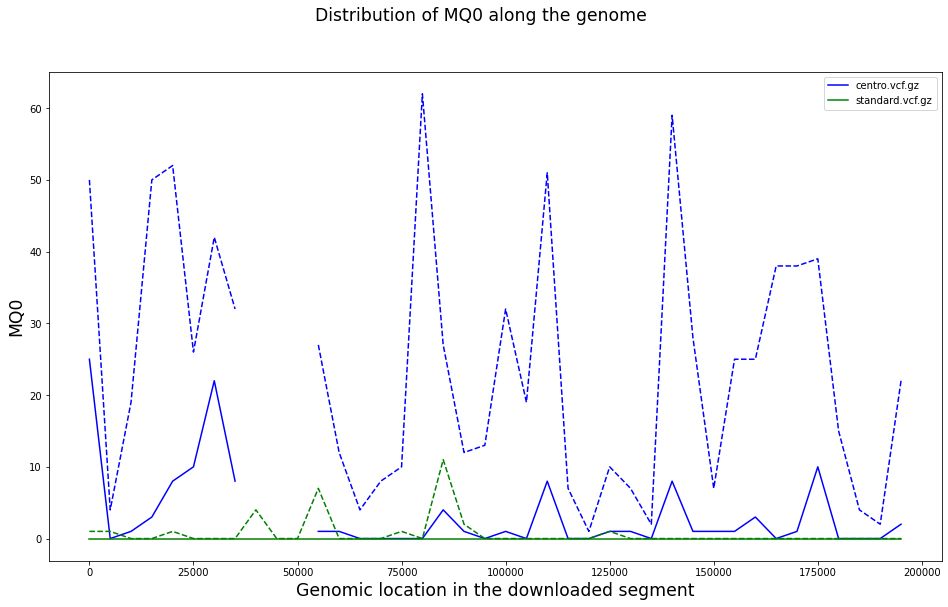

In [12]:
stats = {}
colors = ['b', 'g']
i = 0
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in mq0_wins.items():
    stats[name] = apply_win_funs(nwins, {'median': np.median, '75': functools.partial(np.percentile, q=95)})
    x_lim = [j * size  for j in range(len(stats[name]))]
    ax.plot(x_lim, [x['median'] for x in stats[name]], label=name, color=colors[i])
    ax.plot(x_lim, [x['75'] for x in stats[name]], '--', color=colors[i])
    i += 1
#ax.set_ylim(0, 40)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment', fontsize='xx-large')
ax.set_ylabel('MQ0', fontsize='xx-large')
fig.suptitle('Distribution of MQ0 along the genome', fontsize='xx-large')


Note that we now have two different statistics on `apply_win_funs` (percentile and median). Again, we pass functions as parameters (np.median and np.percentile), with partial function application done on np.percentile.

For the standard.vcf.gz file, the median MQ0 is 0 (it’s plotted at the very bottom and is almost unseen). This is good as it suggests that most sequences involved in the calling of variants map clearly to this area of the genome. For the centro.vcf.gz file, MQ0 is of poor quality. Furthermore, there are areas where the genotype caller cannot find any variants at all (hence the incomplete chart).

Let’s compare heterozygosity with DP, the sample-level annotation. Here, we will plot the fraction of heterozygosity calls as a function of the sample read depth (DP) for every SNP.

In [13]:
def get_sample_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
             continue
        for pos in range(len(rec.genotypes)):
            v1 = f1(rec, pos)
            v2 = f2(rec, pos)
            if v1 is None or v2 == np.iinfo(type(v2)).min:
                continue  # We ignore Nones
            rel[(v1, v2)] += 1
            # careful with the size, floats: round?
        #break
    return rel


rels = {}
for name in names:
    recs = VCF(name)
    rels[name] = get_sample_relation(
        recs,
        lambda rec, pos: 1 if rec.genotypes[pos][0] != rec.genotypes[pos][1] else 0,
        lambda rec, pos: rec.format('DP')[pos][0])

Start by looking for the for loop. the `get_sample_relation` function will traverse all SNP records and apply two functional parameters. The
first parameter determines heterozygosity, whereas the second parameter acquires the sample DP (remember that there is also a variant of DP).
</br>
Now, since the code is as complex as it is, I opted for a naive data structure to be returned
by `get_sample_relation`: a dictionary where the key is a pair of results (in this case,
heterozygosity and DP) and the sum of SNPs that share both values. 

Now, let’s take a look at the plotting code.

This function will take a data structure, as generated by `get_sample_relation`, expecting
that the first parameter of the key tuple is the heterozygosity state (0=homozygote, 1=heterozygote)
and the second parameter is DP. With this, it will generate two lines: one with the fraction of
samples (which are heterozygotes at a certain depth) and the other with the SNP count.

Here, we will use two axes. On the left-hand side, we will have the fraction of heterozygous
SNPs. On the right-hand side, we will have the number of SNPs. We then call `plot_hz_rel`
for both data files.

Text(0.5, 0.98, 'Number of calls per depth and fraction of calls which are Hz')

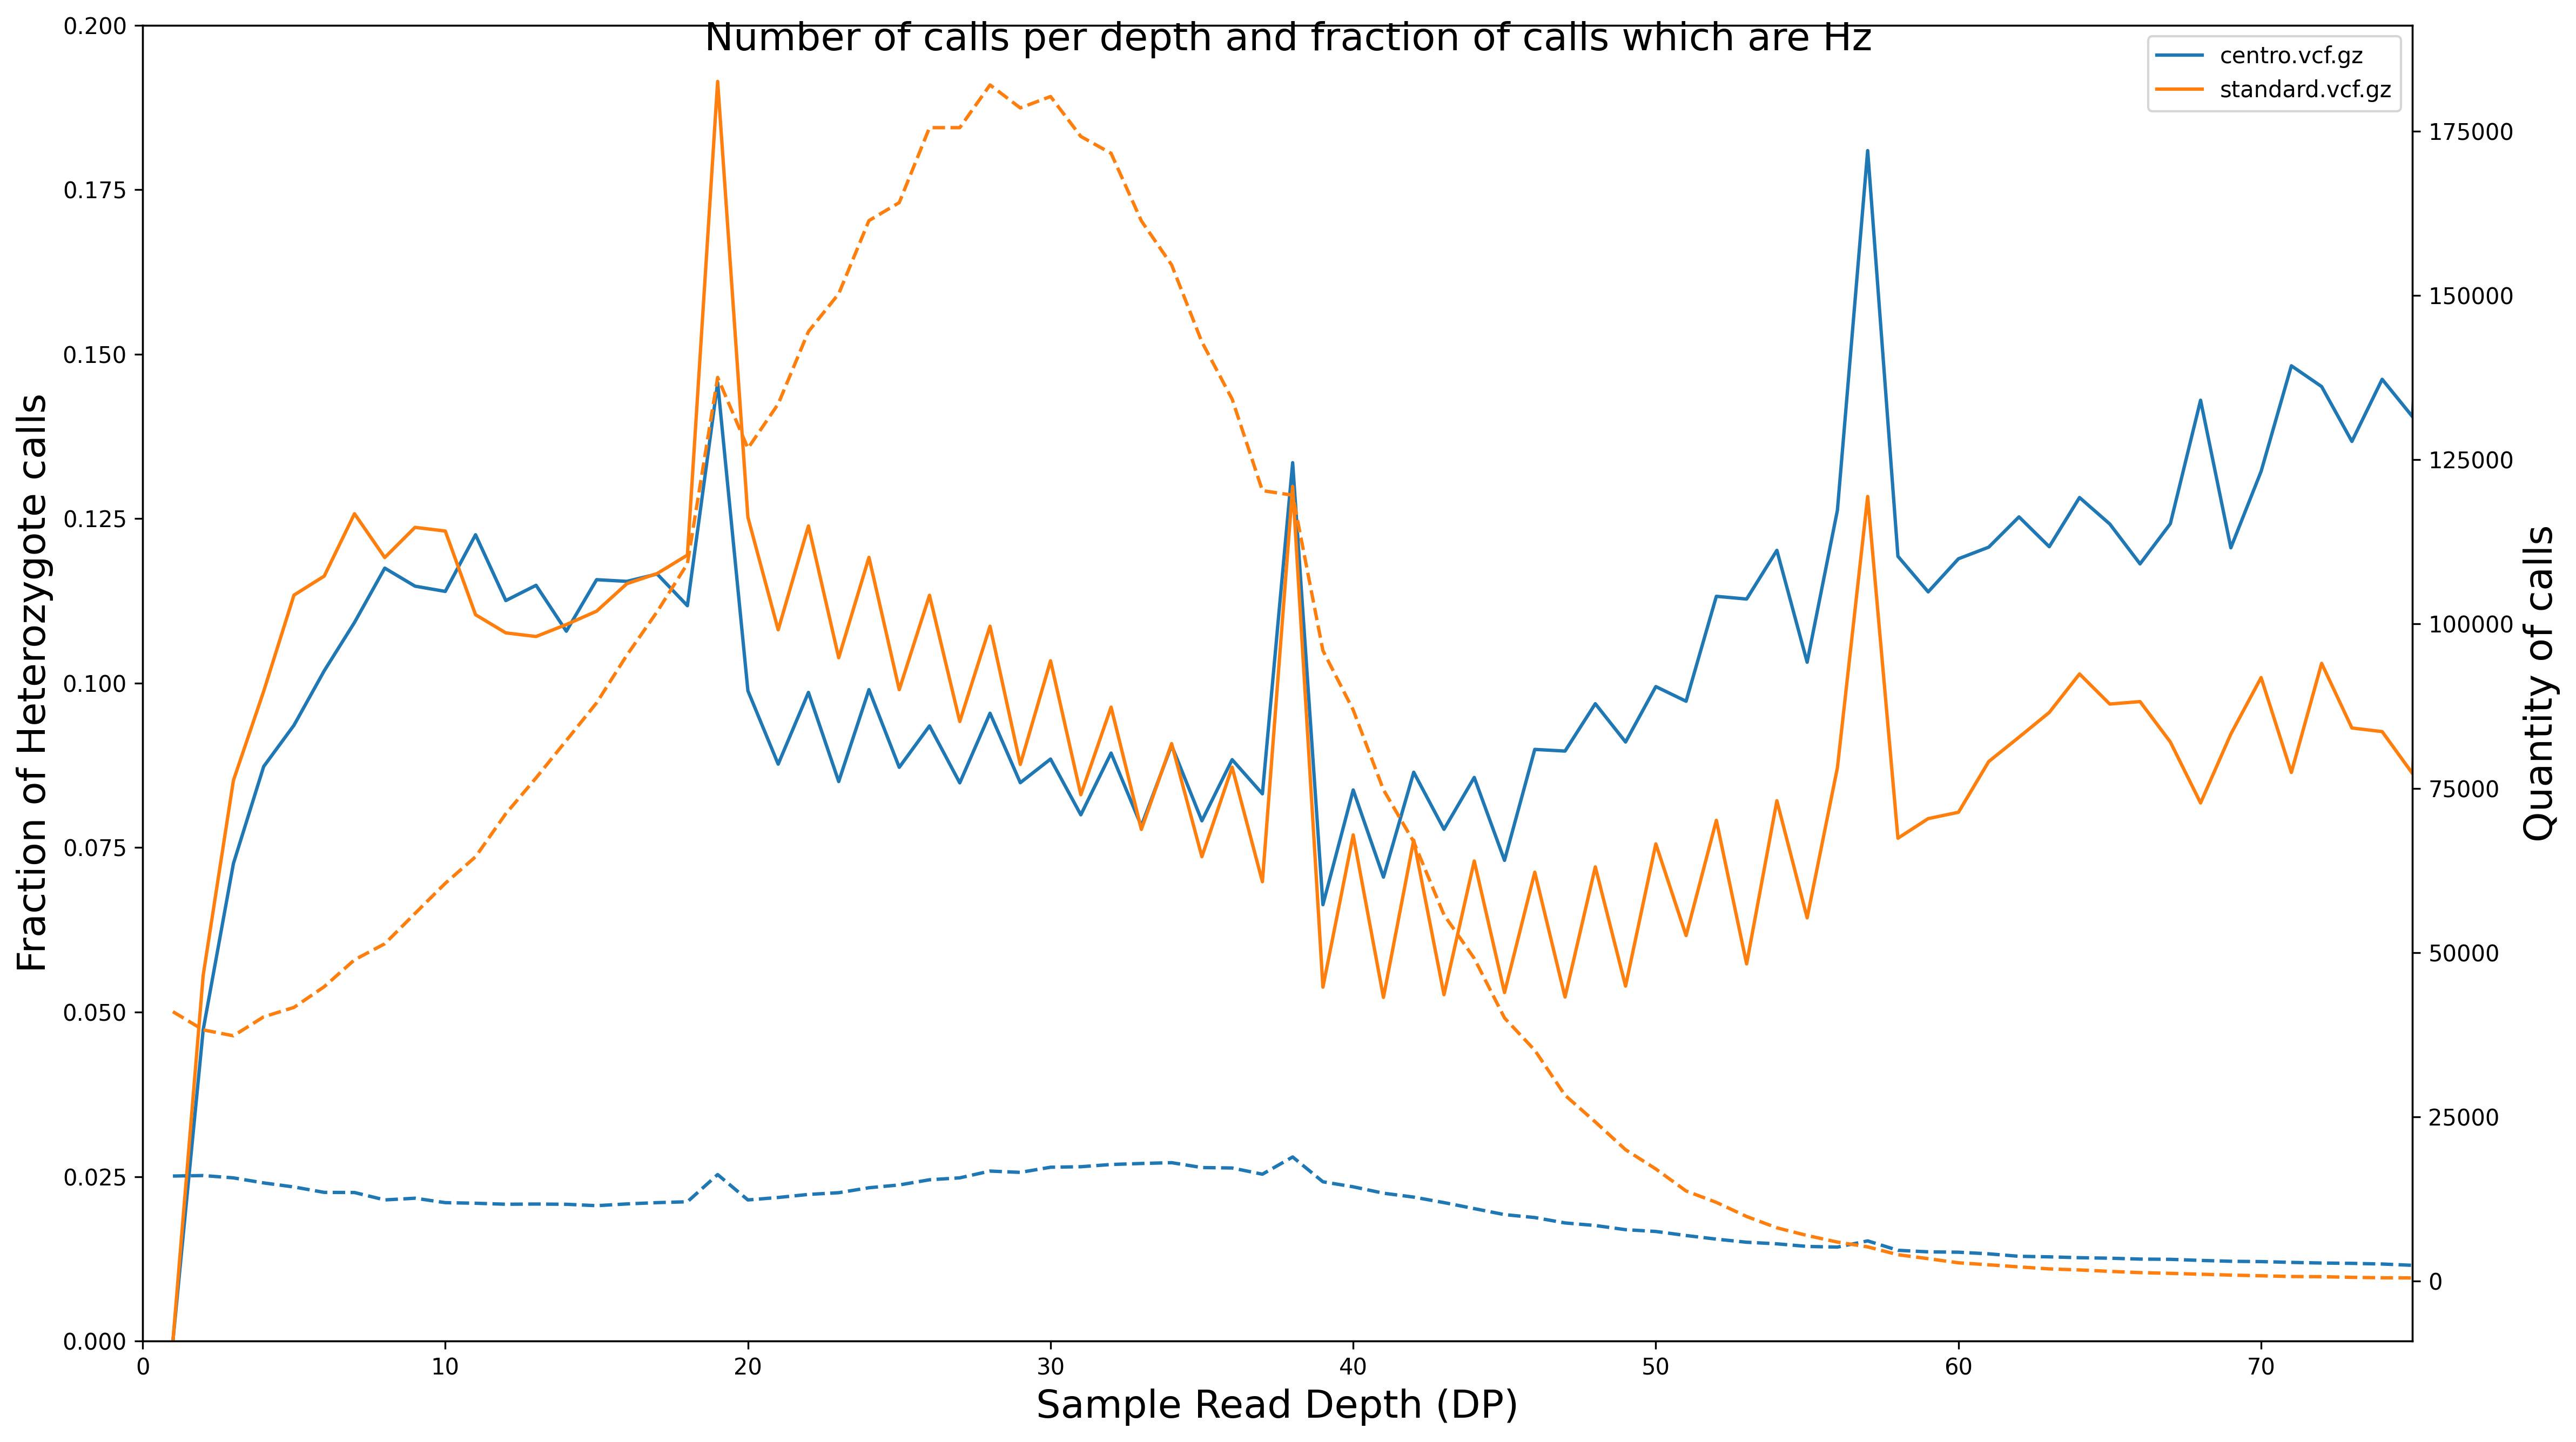

In [15]:
fig, ax = plt.subplots(figsize=(16, 9), dpi=300, tight_layout=True)

def plot_hz_rel(dps, ax, ax2, name, rel):
    frac_hz = []
    cnt_dp = []
    for dp in dps:
        hz = 0.0
        cnt = 0

        for khz, kdp in rel.keys():
            if kdp != dp:
                continue
            cnt += rel[(khz, dp)]
            if khz == 1:
                hz += rel[(khz, dp)]
        frac_hz.append(hz / cnt)
        cnt_dp.append(cnt)
    ax.plot(dps, frac_hz, label=name)
    ax2.plot(dps, cnt_dp, '--', label=name)

ax2 = ax.twinx()
for name, rel in rels.items():
    dps = list(set([x[1] for x in rel.keys()]))
    dps.sort()
    plot_hz_rel(dps, ax, ax2, name, rel)
ax.set_xlim(0, 75)
ax.set_ylim(0, 0.2)
ax2.set_ylabel('Quantity of calls', fontsize='xx-large')
ax.set_ylabel('Fraction of Heterozygote calls', fontsize='xx-large')
ax.set_xlabel('Sample Read Depth (DP)', fontsize='xx-large')
ax.legend()
fig.suptitle('Number of calls per depth and fraction of calls which are Hz',
             fontsize='xx-large')

In the above plot, there are two considerations to take into account. At a very low
depth, the fraction of heterozygote calls is biased—in this case, lower. This makes sense, as the
number of reads per position does not allow you to make a correct estimate of the presence of
both alleles in a sample. Therefore, you should not trust calls at very low depth.
As expected, the number of calls in the centromere is way lower than outside it. The distribution
of SNPs outside the centromere follows a common pattern that you can expect in many datasets.

**Finally, let’s compare the DP variant with a categorical variant-level annotation (EFF).**

EFF is provided by SnpEff and tells us (among many other things) the type of SNP (for example,
intergenic, intronic, coding synonymous, and coding nonsynonymous). The Anopheles dataset
provides this useful annotation. Let’s start by extracting variant-level annotations:

In [16]:
def get_variant_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
             continue
        try:
            v1 = f1(rec)
            v2 = f2(rec)
            if v1 is None or v2 is None:
                continue  # We ignore Nones
            rel[(v1, v2)] += 1
            #careful with the size, floats: round?
        except:
            # This is outside the domain (typically None)
            pass
    return rel

Now, we define the type of effect that we’ll work with and convert its effect
into an integer (as this will allow us to use it as an index—for example, matrices). Now, think
about coding a categorical variable:

In [17]:
accepted_eff = ['INTERGENIC', 'INTRON', 'NON_SYNONYMOUS_CODING', 'SYNONYMOUS_CODING']

def eff_to_int(rec):
    try:
        annot = rec.INFO['EFF']
        master_type = annot.split('(')[0]
        return accepted_eff.index(master_type)
    except ValueError:
        return len(accepted_eff)

We will now traverse the file; the style should be clear to you now:

In [18]:
eff_mq0s = {}
for name in names:
    recs = VCF(name)
    eff_mq0s[name] = get_variant_relation(
        recs,
        lambda r: eff_to_int(r), lambda r: int(r.INFO['DP']))

Finally, we plot the distribution of DP using the SNP effect:

Here, we just print a boxplot for the non-centromeric file, as shown in the following diagram.
The results are as expected: SNPs in coding areas will probably have more depth because they
are in more complex regions that are easier to call than intergenic SNPs:

Text(0.5, 0.98, 'Distribution of variant DP per SNP type')

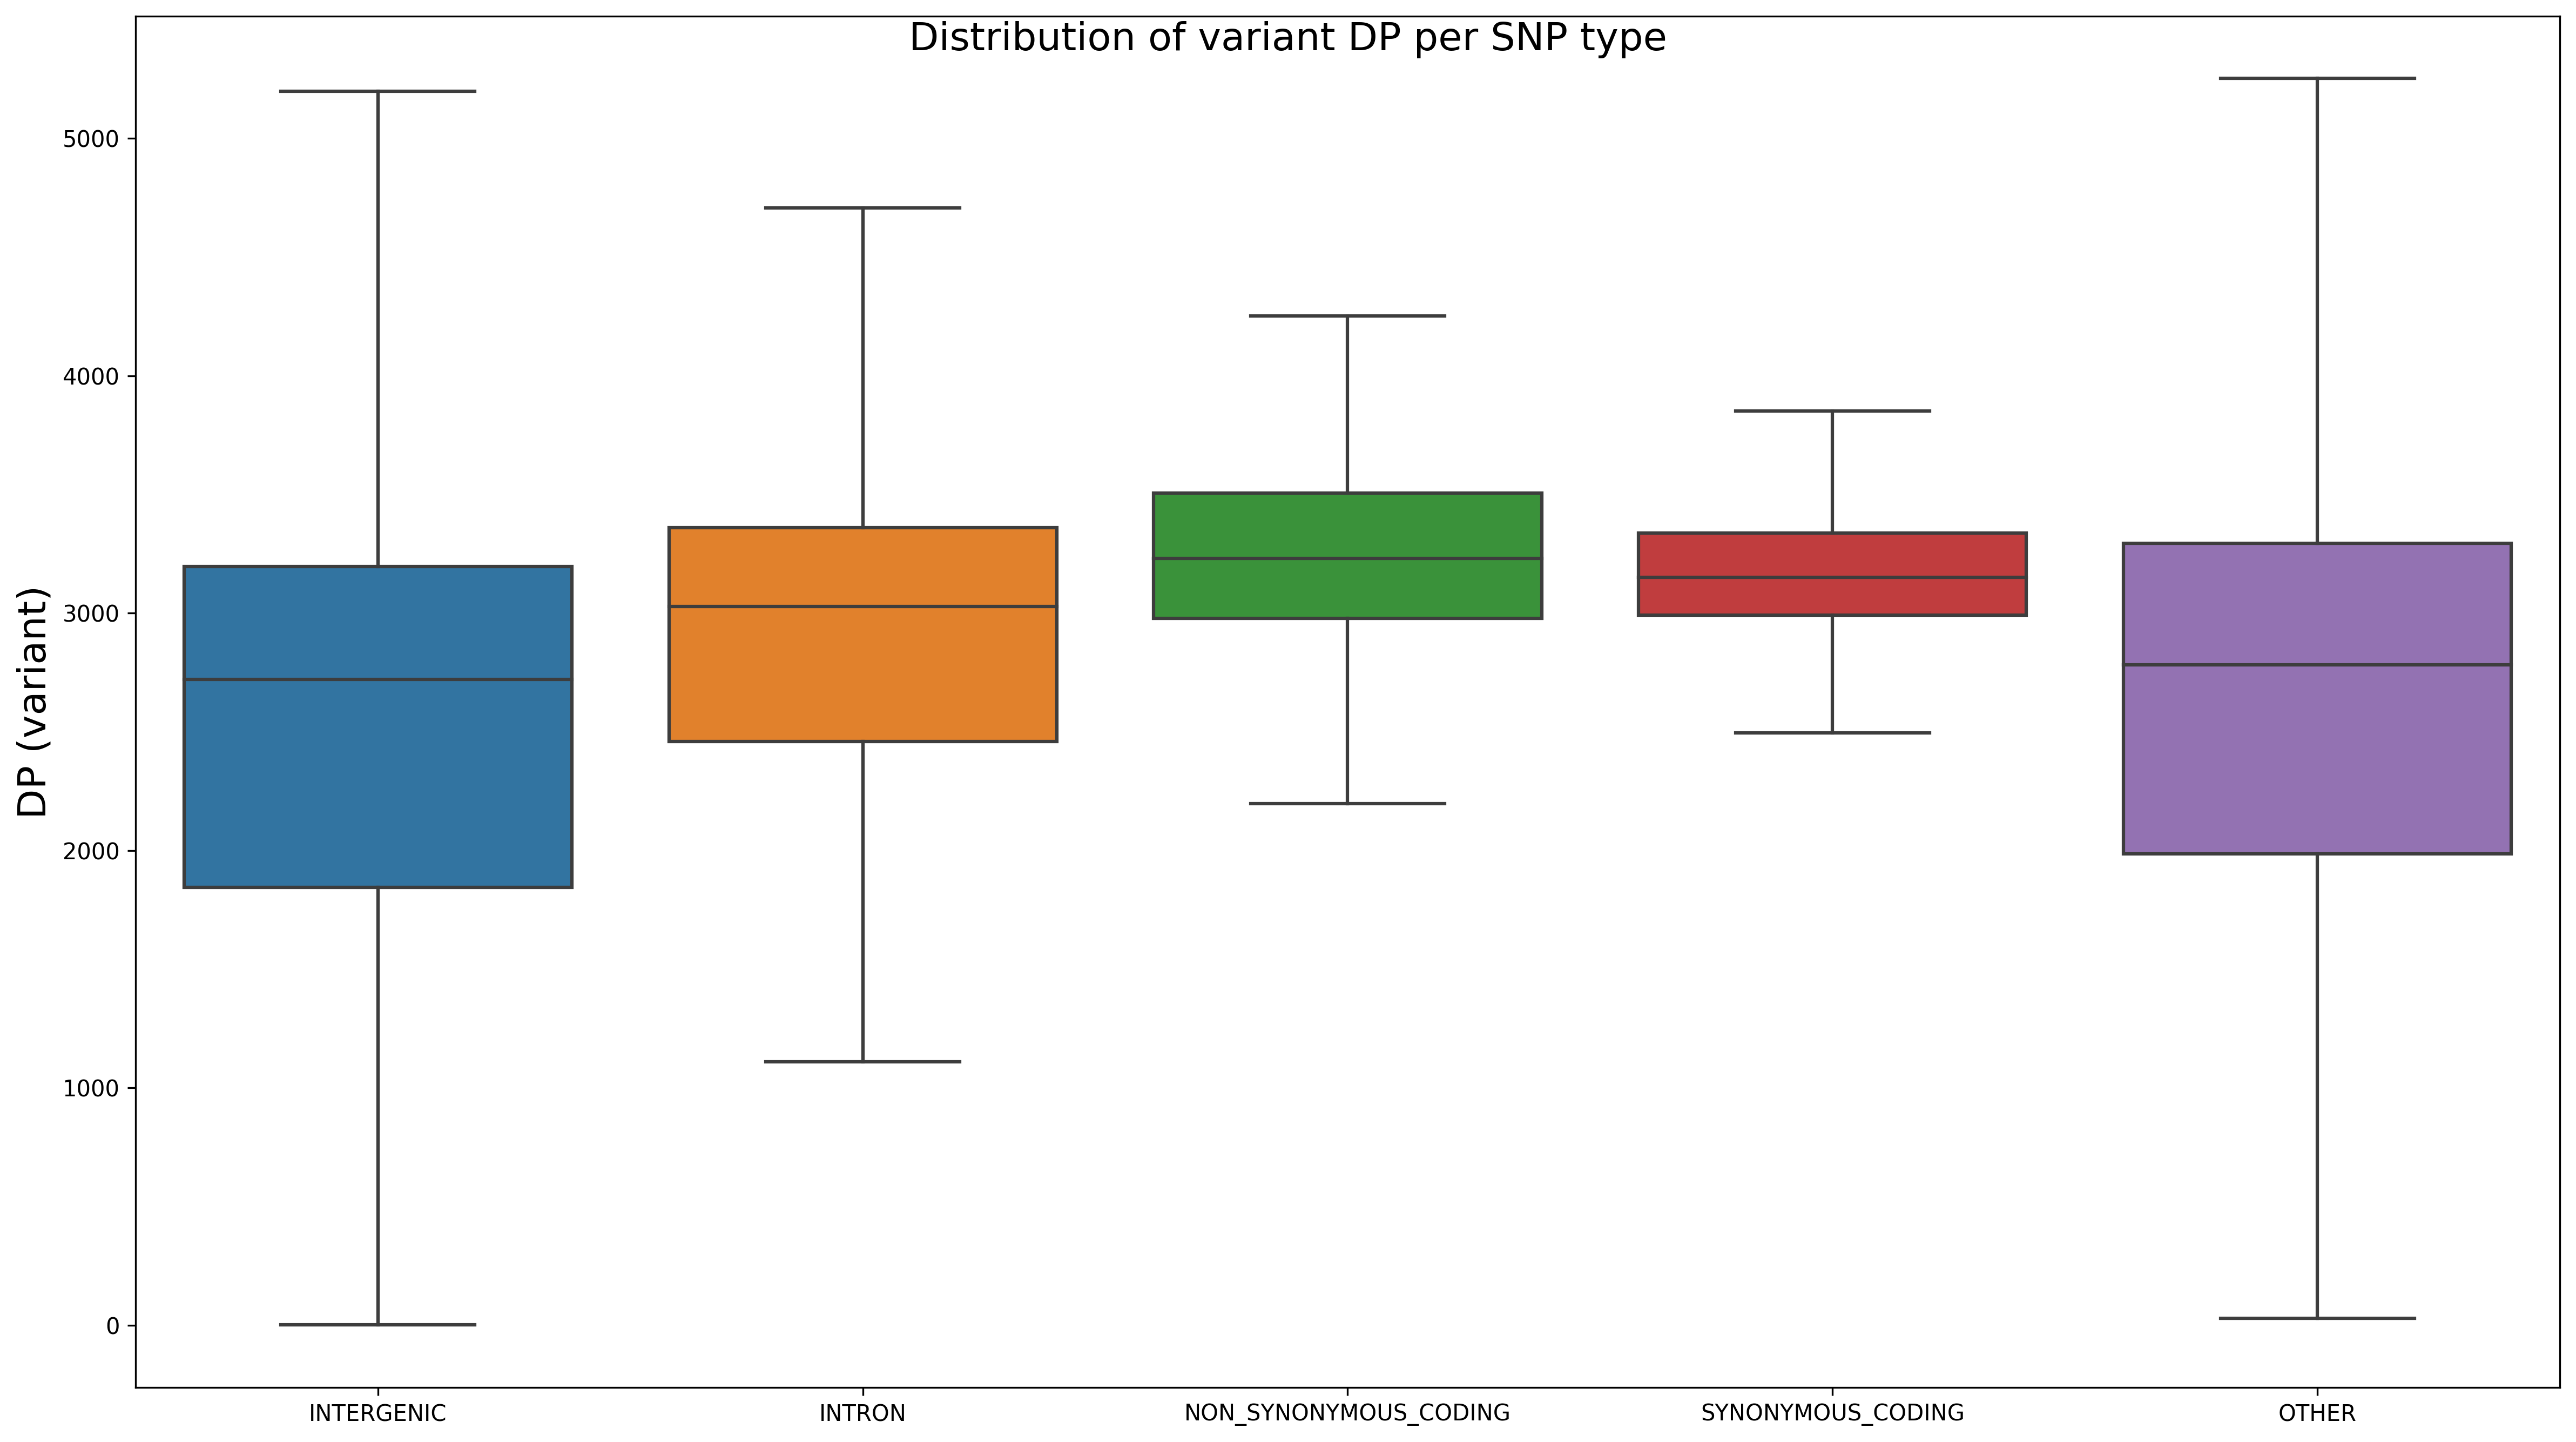

In [19]:
fig, ax = plt.subplots(figsize=(16,9), dpi=300, tight_layout=True)
name = 'standard.vcf.gz'
bp_vals = [[] for x in range(len(accepted_eff) + 1)]
for k, cnt in eff_mq0s[name].items():
    my_eff, mq0 = k
    bp_vals[my_eff].extend([mq0] * cnt)
    #memory usage
#print(bp_vals[-2])
sns.boxplot(data=bp_vals, sym='', ax=ax)
ax.set_xticklabels(accepted_eff + ['OTHER'])
ax.set_ylabel('DP (variant)', fontsize='xx-large')
fig.suptitle('Distribution of variant DP per SNP type', fontsize='xx-large')